# Data Analysis with Pandas for Power Systems

## Introduction

In the power industry, engineers and analysts work with vast amounts of time-series data from various sources including SCADA systems, energy markets, weather stations, and smart meters. This lesson introduces Pandas, Python's primary data manipulation library, through the lens of real-world power system applications.

Pandas excels at handling the structured, time-indexed data that characterizes power system operations. Whether analyzing generator performance, calculating system reliability metrics, or processing market settlements, Pandas provides the tools needed for efficient data analysis.

## Learning Objectives

By the end of this lesson, you will be able to:

1. Load and explore power system datasets using Pandas DataFrames
2. Clean and prepare messy operational data for analysis
3. Perform time-series operations essential for power system analysis
4. Aggregate generation and load data by various categories
5. Merge datasets from different power system sources
6. Calculate key performance indicators from raw operational data

## Prerequisites

This lesson assumes familiarity with:
- Python basics (from Lesson 1)
- NumPy arrays (from Lesson 2)
- Basic power system concepts (generation, load, transmission)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', 10)
pd.set_option('display.precision', 2)

# Check Pandas version
print(f"Pandas version: {pd.__version__}")

Pandas version: 2.3.1


## 1. Introduction to Power System Data

Power system data comes in various formats and from multiple sources. Understanding these data types is crucial for effective analysis. Common data sources include:

### SCADA (Supervisory Control and Data Acquisition)
- Real-time measurements: voltage, current, power flows
- Equipment status: breaker positions, transformer taps
- Typical resolution: 2-4 seconds, often aggregated to 5-minute intervals

### Energy Markets
- Day-ahead and real-time prices
- Generator bids and offers
- Cleared quantities and settlements
- Transmission congestion data

### Weather and Renewable Generation
- Solar irradiance and wind speed measurements
- Temperature data for load forecasting
- Renewable generation forecasts vs. actual production

### Smart Meter Data
- Customer consumption patterns
- Voltage measurements at distribution level
- Time-of-use billing data

Let's start by creating sample datasets that represent these common data types.

In [2]:
# Create sample generation data
np.random.seed(42)
timestamps = pd.date_range('2024-01-01', periods=288, freq='5min')  # 24 hours of 5-minute data

# Generate realistic generation data for different unit types
generation_data = pd.DataFrame({
    'timestamp': timestamps,
    'coal_unit_1': 350 + np.random.normal(0, 5, 288),  # Base load coal ~350 MW
    'coal_unit_2': 275 + np.random.normal(0, 4, 288),  # Base load coal ~275 MW
    'gas_unit_1': 150 + 50 * np.sin(np.linspace(0, 4*np.pi, 288)) + np.random.normal(0, 3, 288),  # Gas following load
    'gas_unit_2': 100 + 30 * np.sin(np.linspace(0, 4*np.pi, 288)) + np.random.normal(0, 2, 288),  # Gas peaker
    'wind_farm': np.maximum(0, 80 * np.abs(np.sin(np.linspace(0, 8*np.pi, 288))) + np.random.normal(0, 10, 288)),  # Variable wind
    'solar_farm': np.maximum(0, 50 * np.sin(np.linspace(0, 2*np.pi, 288))**2) * (timestamps.hour >= 6) * (timestamps.hour <= 18)  # Solar pattern
})

# Ensure non-negative generation
for col in generation_data.columns[1:]:
    generation_data[col] = generation_data[col].clip(lower=0)

print("Sample Generation Data:")
print(generation_data.head(10))

Sample Generation Data:
            timestamp  coal_unit_1  coal_unit_2  gas_unit_1  gas_unit_2  \
0 2024-01-01 00:00:00       352.48       276.12      150.71       98.77   
1 2024-01-01 00:05:00       349.31       272.51      154.50      100.54   
2 2024-01-01 00:10:00       353.24       274.17      149.94      103.20   
3 2024-01-01 00:15:00       357.62       273.03      159.98      104.60   
4 2024-01-01 00:20:00       348.83       272.64      159.73      106.54   
5 2024-01-01 00:25:00       348.83       278.40      159.61      110.54   
6 2024-01-01 00:30:00       357.90       276.43      164.88      107.44   
7 2024-01-01 00:35:00       353.84       272.23      171.90      107.46   
8 2024-01-01 00:40:00       347.65       278.60      167.70      107.54   
9 2024-01-01 00:45:00       352.71       276.23      169.94      110.06   

   wind_farm  solar_farm  
0       0.00         0.0  
1       0.00         0.0  
2      30.36         0.0  
3      30.87         0.0  
4      20.57   

In [3]:
# Create sample load data with typical daily pattern
base_load = 600  # MW
load_pattern = (base_load + 
                100 * np.sin(np.linspace(-np.pi/2, 3*np.pi/2, 288)) +  # Daily pattern
                50 * np.sin(np.linspace(0, 48*np.pi, 288)) +  # Small variations
                np.random.normal(0, 10, 288))  # Random noise

load_data = pd.DataFrame({
    'timestamp': timestamps,
    'system_load': load_pattern,
    'temperature': 20 + 10 * np.sin(np.linspace(-np.pi/2, 3*np.pi/2, 288)) + np.random.normal(0, 2, 288)
})

# Create sample market price data (correlated with load)
load_normalized = (load_data['system_load'] - load_data['system_load'].min()) / (load_data['system_load'].max() - load_data['system_load'].min())
base_price = 30  # $/MWh
price_data = pd.DataFrame({
    'timestamp': timestamps,
    'lmp_node_1': base_price + 20 * load_normalized + np.random.normal(0, 2, 288),
    'lmp_node_2': base_price + 20 * load_normalized + np.random.normal(0, 2, 288) + 2,  # Slightly higher due to congestion
    'lmp_node_3': base_price + 20 * load_normalized + np.random.normal(0, 2, 288) - 1
})

print("\nSample Load Data:")
print(load_data.head())
print("\nSample Price Data:")
print(price_data.head())


Sample Load Data:
            timestamp  system_load  temperature
0 2024-01-01 00:00:00       506.63        10.73
1 2024-01-01 00:05:00       536.84        13.68
2 2024-01-01 00:10:00       545.30         9.56
3 2024-01-01 00:15:00       537.25         9.32
4 2024-01-01 00:20:00       547.50        10.00

Sample Price Data:
            timestamp  lmp_node_1  lmp_node_2  lmp_node_3
0 2024-01-01 00:00:00       34.05       40.57       33.49
1 2024-01-01 00:05:00       32.47       44.69       35.59
2 2024-01-01 00:10:00       38.28       40.22       37.70
3 2024-01-01 00:15:00       34.02       38.13       31.01
4 2024-01-01 00:20:00       37.26       40.21       34.93


## 2. DataFrames for Power System Data

DataFrames are the core data structure in Pandas, perfect for representing the tabular data common in power systems. Let's explore how to work with DataFrames in a power system context.

### Creating DataFrames

DataFrames can be created from various sources:
- CSV files (most common for power system data exports)
- Excel files (common for market reports)
- Databases (real-time SCADA systems)
- APIs (ISO/RTO market data)
- Python dictionaries and lists

In [4]:
# Save our sample data to CSV for realistic file loading examples
generation_data.to_csv('generation_data.csv', index=False)
load_data.to_csv('load_data.csv', index=False)
price_data.to_csv('market_prices.csv', index=False)

# Load data from CSV - the most common scenario
gen_df = pd.read_csv('generation_data.csv', parse_dates=['timestamp'])
print("Loaded generation data shape:", gen_df.shape)
print("\nData types after loading:")
print(gen_df.dtypes)

Loaded generation data shape: (288, 7)

Data types after loading:
timestamp      datetime64[ns]
coal_unit_1           float64
coal_unit_2           float64
gas_unit_1            float64
gas_unit_2            float64
wind_farm             float64
solar_farm            float64
dtype: object


In [5]:
# Create a more complex DataFrame with generator characteristics
generator_info = pd.DataFrame({
    'unit_name': ['coal_unit_1', 'coal_unit_2', 'gas_unit_1', 'gas_unit_2', 'wind_farm', 'solar_farm'],
    'fuel_type': ['Coal', 'Coal', 'Natural Gas', 'Natural Gas', 'Wind', 'Solar'],
    'capacity_mw': [400, 300, 200, 150, 100, 60],
    'min_output_mw': [200, 150, 50, 30, 0, 0],
    'ramp_rate_mw_min': [5, 4, 10, 15, 100, 60],  # MW/minute ramp rate
    'heat_rate_btu_kwh': [9500, 9800, 7500, 8500, 0, 0],  # 0 for renewables
    'variable_cost_per_mwh': [25, 26, 35, 40, 0, 0]
})

print("Generator Characteristics:")
print(generator_info)
print("\nFuel type distribution:")
print(generator_info['fuel_type'].value_counts())

Generator Characteristics:
     unit_name    fuel_type  capacity_mw  min_output_mw  ramp_rate_mw_min  \
0  coal_unit_1         Coal          400            200                 5   
1  coal_unit_2         Coal          300            150                 4   
2   gas_unit_1  Natural Gas          200             50                10   
3   gas_unit_2  Natural Gas          150             30                15   
4    wind_farm         Wind          100              0               100   
5   solar_farm        Solar           60              0                60   

   heat_rate_btu_kwh  variable_cost_per_mwh  
0               9500                     25  
1               9800                     26  
2               7500                     35  
3               8500                     40  
4                  0                      0  
5                  0                      0  

Fuel type distribution:
fuel_type
Coal           2
Natural Gas    2
Wind           1
Solar          1
Name: co

### Exploring DataFrames

Understanding your data is the first step in any analysis. Pandas provides numerous methods for data exploration.

In [6]:
# Basic exploration of generation data
print("=== DataFrame Info ===")
print(gen_df.info())

print("\n=== Statistical Summary ===")
print(gen_df.describe())

print("\n=== First and Last Timestamps ===")
print(f"Data starts at: {gen_df['timestamp'].min()}")
print(f"Data ends at: {gen_df['timestamp'].max()}")
print(f"Duration: {gen_df['timestamp'].max() - gen_df['timestamp'].min()}")

print("\n=== Sample Data Points ===")
print(gen_df.sample(5))  # Random sample of 5 rows

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    288 non-null    datetime64[ns]
 1   coal_unit_1  288 non-null    float64       
 2   coal_unit_2  288 non-null    float64       
 3   gas_unit_1   288 non-null    float64       
 4   gas_unit_2   288 non-null    float64       
 5   wind_farm    288 non-null    float64       
 6   solar_farm   288 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 15.9 KB
None

=== Statistical Summary ===
                 timestamp  coal_unit_1  coal_unit_2  gas_unit_1  gas_unit_2  \
count                  288       288.00       288.00      288.00      288.00   
mean   2024-01-01 11:57:30       349.94       274.90      150.13      100.30   
min    2024-01-01 00:00:00       333.79       265.11       96.34       65.98   
25%    2024-01-01 

### Setting Index for Time Series Data

For power system data, it's often beneficial to set the timestamp as the index. This enables powerful time-based operations.

In [7]:
# Set timestamp as index
gen_df_indexed = gen_df.set_index('timestamp')
load_df = pd.read_csv('load_data.csv', parse_dates=['timestamp'], index_col='timestamp')
price_df = pd.read_csv('market_prices.csv', parse_dates=['timestamp'], index_col='timestamp')

print("Generation data with timestamp index:")
print(gen_df_indexed.head())

# Time-based selection becomes easy
print("\n=== Morning generation (6 AM - 12 PM) ===")
morning_gen = gen_df_indexed.between_time('06:00', '12:00')
print(f"Average morning generation by unit:")
print(morning_gen.mean())

Generation data with timestamp index:
                     coal_unit_1  coal_unit_2  gas_unit_1  gas_unit_2  \
timestamp                                                               
2024-01-01 00:00:00       352.48       276.12      150.71       98.77   
2024-01-01 00:05:00       349.31       272.51      154.50      100.54   
2024-01-01 00:10:00       353.24       274.17      149.94      103.20   
2024-01-01 00:15:00       357.62       273.03      159.98      104.60   
2024-01-01 00:20:00       348.83       272.64      159.73      106.54   

                     wind_farm  solar_farm  
timestamp                                   
2024-01-01 00:00:00       0.00         0.0  
2024-01-01 00:05:00       0.00         0.0  
2024-01-01 00:10:00      30.36         0.0  
2024-01-01 00:15:00      30.87         0.0  
2024-01-01 00:20:00      20.57         0.0  

=== Morning generation (6 AM - 12 PM) ===
Average morning generation by unit:
coal_unit_1    349.74
coal_unit_2    275.54
gas_unit_1  

```{admonition} Exercise 1: Load and Explore Generation Data
:class: tip

Given the generation data, identify the peak demand period and determine which generators were online during that period.

Tasks:
1. Calculate total generation for each timestamp
2. Find the timestamp with maximum total generation
3. Identify which units were generating > 10 MW during peak
4. Calculate the contribution percentage of each fuel type during peak

```

In [8]:
# Exercise 1: Your code here
# Find peak demand period and analyze generation mix

# Your solution:

In [9]:
# Solution
# 1. Calculate total generation for each timestamp
gen_df_indexed['total_generation'] = gen_df_indexed.sum(axis=1)

# 2. Find the timestamp with maximum total generation
peak_time = gen_df_indexed['total_generation'].idxmax()
peak_generation = gen_df_indexed['total_generation'].max()

print(f"Peak demand occurred at: {peak_time}")
print(f"Total generation at peak: {peak_generation:.1f} MW")

# 3. Identify which units were generating > 10 MW during peak
peak_data = gen_df_indexed.loc[peak_time]
online_units = peak_data[peak_data > 10].drop('total_generation')
print(f"\nUnits online during peak (>10 MW):")
for unit, output in online_units.items():
    print(f"  {unit}: {output:.1f} MW")

# 4. Calculate fuel type contribution during peak
# First, reshape generation data to long format
gen_long = gen_df_indexed.drop('total_generation', axis=1).reset_index()
gen_melted = pd.melt(gen_long, id_vars=['timestamp'], var_name='unit_name', value_name='generation')

# Merge with generator info to get fuel types
gen_with_fuel = gen_melted.merge(generator_info[['unit_name', 'fuel_type']], on='unit_name')

# Filter for peak time and calculate fuel type percentages
peak_fuel_mix = gen_with_fuel[gen_with_fuel['timestamp'] == peak_time].groupby('fuel_type')['generation'].sum()
peak_fuel_pct = (peak_fuel_mix / peak_fuel_mix.sum() * 100).round(1)

print(f"\nFuel type contribution at peak:")
for fuel, pct in peak_fuel_pct.items():
    print(f"  {fuel}: {pct}%")

Peak demand occurred at: 2024-01-01 15:55:00
Total generation at peak: 1074.8 MW

Units online during peak (>10 MW):
  coal_unit_1: 354.3 MW
  coal_unit_2: 279.5 MW
  gas_unit_1: 199.0 MW
  gas_unit_2: 124.9 MW
  wind_farm: 80.0 MW
  solar_farm: 37.2 MW

Fuel type contribution at peak:
  Coal: 59.0%
  Natural Gas: 30.1%
  Solar: 3.5%
  Wind: 7.4%


## 3. Data Cleaning and Preparation

Real-world power system data often contains quality issues that must be addressed before analysis. Common problems include:

- Missing SCADA values due to communication failures
- Unrealistic measurements (negative generation, voltages outside acceptable ranges)
- Timestamp irregularities in market data
- Duplicate entries from redundant systems

Let's create a realistic "messy" dataset and clean it.

In [10]:
# Create a messy transmission line flow dataset
np.random.seed(42)
line_timestamps = pd.date_range('2024-01-01', periods=300, freq='5min')

# Generate base flow data
line_flows = pd.DataFrame({
    'timestamp': line_timestamps,
    'line_1_flow_mw': 150 + 30 * np.sin(np.linspace(0, 4*np.pi, 300)) + np.random.normal(0, 5, 300),
    'line_2_flow_mw': 200 + 40 * np.sin(np.linspace(0, 4*np.pi, 300)) + np.random.normal(0, 7, 300),
    'line_3_flow_mw': 100 + 20 * np.sin(np.linspace(0, 4*np.pi, 300)) + np.random.normal(0, 4, 300),
    'line_1_limit_mw': 250,
    'line_2_limit_mw': 300,
    'line_3_limit_mw': 150
})

# Introduce data quality issues
# 1. Missing values (simulating SCADA dropouts)
missing_indices = np.random.choice(line_flows.index[10:290], size=20, replace=False)
line_flows.loc[missing_indices, 'line_1_flow_mw'] = np.nan
line_flows.loc[missing_indices[::2], 'line_2_flow_mw'] = np.nan

# 2. Unrealistic values (measurement errors)
error_indices = np.random.choice(line_flows.index[20:280], size=10, replace=False)
line_flows.loc[error_indices[::2], 'line_2_flow_mw'] = -50  # Negative flow (could be valid for bidirectional lines)
line_flows.loc[error_indices[1::2], 'line_3_flow_mw'] = 500  # Way over limit

# 3. Duplicate timestamps (data collection issues)
duplicate_indices = [50, 100, 150]
for idx in duplicate_indices:
    line_flows.loc[idx-0.5] = line_flows.loc[idx].copy()
    line_flows.loc[idx-0.5, 'timestamp'] = line_flows.loc[idx, 'timestamp']

line_flows = line_flows.sort_values('timestamp').reset_index(drop=True)

print("Messy transmission line data:")
print(f"Shape: {line_flows.shape}")
print(f"\nMissing values per column:")
print(line_flows.isnull().sum())
print(f"\nDuplicate timestamps: {line_flows['timestamp'].duplicated().sum()}")
print(f"\nSample of problematic data:")
print(line_flows[line_flows['line_3_flow_mw'] > 300])

Messy transmission line data:
Shape: (303, 7)

Missing values per column:
timestamp           0
line_1_flow_mw     21
line_2_flow_mw     11
line_3_flow_mw      0
line_1_limit_mw     0
line_2_limit_mw     0
line_3_limit_mw     0
dtype: int64

Duplicate timestamps: 3

Sample of problematic data:
              timestamp  line_1_flow_mw  line_2_flow_mw  line_3_flow_mw  \
26  2024-01-01 02:10:00          170.88          243.62           500.0   
181 2024-01-01 14:50:00          176.61          258.80           500.0   
228 2024-01-01 18:45:00          154.50          186.11           500.0   
263 2024-01-01 21:40:00          115.44          162.12           500.0   
281 2024-01-01 23:10:00          127.18          158.75           500.0   

     line_1_limit_mw  line_2_limit_mw  line_3_limit_mw  
26               250              300              150  
181              250              300              150  
228              250              300              150  
263              250      

### Data Cleaning Steps

Now let's clean this dataset using domain knowledge about transmission line operations.

In [11]:
# Step 1: Handle duplicate timestamps
print("=== Handling Duplicate Timestamps ===")
# Keep the first occurrence (could also average them)
line_flows_clean = line_flows.drop_duplicates(subset='timestamp', keep='first')
print(f"Removed {len(line_flows) - len(line_flows_clean)} duplicate timestamps")

# Step 2: Identify and handle unrealistic values
print("\n=== Handling Unrealistic Values ===")
# For transmission lines, flows should typically be within [-limit, +limit]
for line_num in [1, 2, 3]:
    flow_col = f'line_{line_num}_flow_mw'
    limit_col = f'line_{line_num}_limit_mw'
    
    # Find values exceeding limits by more than 10% (allowing some measurement tolerance)
    mask = abs(line_flows_clean[flow_col]) > line_flows_clean[limit_col] * 1.1
    unrealistic_count = mask.sum()
    
    if unrealistic_count > 0:
        print(f"Line {line_num}: {unrealistic_count} flows exceed limit by >10%")
        # Replace with NaN to handle as missing data
        line_flows_clean.loc[mask, flow_col] = np.nan

# Step 3: Handle missing values
print("\n=== Handling Missing Values ===")
print("Missing values before interpolation:")
print(line_flows_clean.isnull().sum())

# For time series data, interpolation is often appropriate
# Use linear interpolation with a limit on gap size
line_flows_clean[['line_1_flow_mw', 'line_2_flow_mw', 'line_3_flow_mw']] = \
    line_flows_clean[['line_1_flow_mw', 'line_2_flow_mw', 'line_3_flow_mw']].interpolate(
        method='linear', 
        limit=3,  # Don't interpolate gaps larger than 3 periods (15 minutes)
        limit_direction='both'
    )

# Fill any remaining NaN values with forward fill (last known good value)
line_flows_clean[['line_1_flow_mw', 'line_2_flow_mw', 'line_3_flow_mw']] = \
    line_flows_clean[['line_1_flow_mw', 'line_2_flow_mw', 'line_3_flow_mw']].fillna(method='ffill')

print("\nMissing values after interpolation:")
print(line_flows_clean.isnull().sum())

# Step 4: Validate cleaned data
print("\n=== Data Validation ===")
for line_num in [1, 2, 3]:
    flow_col = f'line_{line_num}_flow_mw'
    limit_col = f'line_{line_num}_limit_mw'
    
    max_flow = line_flows_clean[flow_col].max()
    min_flow = line_flows_clean[flow_col].min()
    limit = line_flows_clean[limit_col].iloc[0]
    
    print(f"Line {line_num}: Flow range [{min_flow:.1f}, {max_flow:.1f}] MW, Limit: {limit} MW")

=== Handling Duplicate Timestamps ===
Removed 3 duplicate timestamps

=== Handling Unrealistic Values ===
Line 3: 5 flows exceed limit by >10%

=== Handling Missing Values ===
Missing values before interpolation:
timestamp           0
line_1_flow_mw     20
line_2_flow_mw     10
line_3_flow_mw      5
line_1_limit_mw     0
line_2_limit_mw     0
line_3_limit_mw     0
dtype: int64

Missing values after interpolation:
timestamp          0
line_1_flow_mw     0
line_2_flow_mw     0
line_3_flow_mw     0
line_1_limit_mw    0
line_2_limit_mw    0
line_3_limit_mw    0
dtype: int64

=== Data Validation ===
Line 1: Flow range [110.5, 192.0] MW, Limit: 250 MW
Line 2: Flow range [-50.0, 258.8] MW, Limit: 300 MW
Line 3: Flow range [72.0, 126.4] MW, Limit: 150 MW


In [12]:
# Create sample voltage data with issues
voltage_data = pd.DataFrame({
    'timestamp': pd.date_range('2024-01-01', periods=100, freq='5min'),
    'bus_1_voltage_pu': np.random.normal(1.0, 0.01, 100),
    'bus_2_voltage_pu': np.random.normal(0.99, 0.01, 100),
    'bus_3_voltage_pu': np.random.normal(1.01, 0.01, 100)
})

# Add some data quality issues
voltage_data.loc[10:12, 'bus_1_voltage_pu'] = np.nan
voltage_data.loc[25, 'bus_2_voltage_pu'] = 0.5  # Too low
voltage_data.loc[45, 'bus_3_voltage_pu'] = 1.2  # Too high
voltage_data.loc[99.5] = voltage_data.loc[99]  # Duplicate

# Exercise 2: Your code here
# Clean the voltage data

# Your solution:

```{admonition} Exercise 2: Clean Power System Data
:class: tip

You have been given a dataset of voltage measurements from multiple buses with data quality issues. Clean the data by:

1. Removing duplicate timestamps
2. Identifying voltages outside acceptable range (0.95-1.05 p.u.)
3. Handling missing values appropriately
4. Creating a summary of data quality issues found

```

In [13]:
# Solution
# Step 1: Remove duplicates
print("Original data shape:", voltage_data.shape)
voltage_clean = voltage_data.drop_duplicates(subset='timestamp', keep='first')
duplicates_removed = len(voltage_data) - len(voltage_clean)
print(f"Removed {duplicates_removed} duplicate timestamps")

# Step 2: Identify out-of-range voltages
voltage_cols = ['bus_1_voltage_pu', 'bus_2_voltage_pu', 'bus_3_voltage_pu']
out_of_range_summary = {}

for col in voltage_cols:
    mask = (voltage_clean[col] < 0.95) | (voltage_clean[col] > 1.05)
    out_of_range_count = mask.sum()
    out_of_range_summary[col] = out_of_range_count
    
    if out_of_range_count > 0:
        print(f"\n{col}: {out_of_range_count} values outside [0.95, 1.05] p.u.")
        print(f"  Out of range values: {voltage_clean.loc[mask, col].values}")
        # Replace with NaN
        voltage_clean.loc[mask, col] = np.nan

# Step 3: Handle missing values
print("\n=== Missing Values ===")
print("Before cleaning:")
print(voltage_clean[voltage_cols].isnull().sum())

# Interpolate missing values
voltage_clean[voltage_cols] = voltage_clean[voltage_cols].interpolate(method='linear', limit=2)
# Fill any remaining with forward fill
voltage_clean[voltage_cols] = voltage_clean[voltage_cols].fillna(method='ffill')

print("\nAfter cleaning:")
print(voltage_clean[voltage_cols].isnull().sum())

# Step 4: Data quality summary
print("\n=== Data Quality Summary ===")
print(f"Total records: {len(voltage_data)}")
print(f"Duplicate timestamps removed: {duplicates_removed}")
print("\nOut-of-range voltages by bus:")
for bus, count in out_of_range_summary.items():
    print(f"  {bus}: {count}")

print("\nCleaned data statistics:")
print(voltage_clean[voltage_cols].describe())

# Verify all voltages are now in acceptable range
for col in voltage_cols:
    min_v = voltage_clean[col].min()
    max_v = voltage_clean[col].max()
    print(f"{col}: range [{min_v:.4f}, {max_v:.4f}] p.u.")

Original data shape: (101, 4)
Removed 1 duplicate timestamps

bus_2_voltage_pu: 1 values outside [0.95, 1.05] p.u.
  Out of range values: [0.5]

bus_3_voltage_pu: 1 values outside [0.95, 1.05] p.u.
  Out of range values: [1.2]

=== Missing Values ===
Before cleaning:
bus_1_voltage_pu    3
bus_2_voltage_pu    1
bus_3_voltage_pu    1
dtype: int64

After cleaning:
bus_1_voltage_pu    0
bus_2_voltage_pu    0
bus_3_voltage_pu    0
dtype: int64

=== Data Quality Summary ===
Total records: 101
Duplicate timestamps removed: 1

Out-of-range voltages by bus:
  bus_1_voltage_pu: 0
  bus_2_voltage_pu: 1
  bus_3_voltage_pu: 1

Cleaned data statistics:
       bus_1_voltage_pu  bus_2_voltage_pu  bus_3_voltage_pu
count          1.00e+02          1.00e+02            100.00
mean           1.00e+00          9.90e-01              1.01
std            9.96e-03          9.55e-03              0.01
min            9.78e-01          9.64e-01              0.99
25%            9.93e-01          9.84e-01            

## 4. Time Series Operations

Power system data is inherently temporal. Operations like resampling, rolling calculations, and shift operations are essential for analysis. Let's explore these capabilities.

In [14]:
# Ensure we have datetime index
gen_df = pd.read_csv('generation_data.csv', parse_dates=['timestamp'], index_col='timestamp')

# 1. Resampling - Convert 5-minute to hourly data
print("=== Resampling: 5-minute to Hourly ===")
gen_hourly = gen_df.resample('1H').mean()  # Average for generation
print(f"Original shape: {gen_df.shape}")
print(f"Hourly shape: {gen_hourly.shape}")
print("\nFirst few hourly averages:")
print(gen_hourly.head())

# For energy calculations, use sum
energy_hourly_mwh = gen_df.resample('1H').sum() / 12  # Convert MW to MWh (12 x 5-minute periods)
print("\nHourly energy generation (MWh):")
print(energy_hourly_mwh.head())

=== Resampling: 5-minute to Hourly ===
Original shape: (288, 6)
Hourly shape: (24, 6)

First few hourly averages:
                     coal_unit_1  coal_unit_2  gas_unit_1  gas_unit_2  \
timestamp                                                               
2024-01-01 00:00:00       351.48       275.51      162.44      107.23   
2024-01-01 01:00:00       347.04       275.66      184.18      121.60   
2024-01-01 02:00:00       349.03       276.83      198.18      129.79   
2024-01-01 03:00:00       348.34       275.10      199.48      129.37   
2024-01-01 04:00:00       350.24       273.26      184.85      121.60   

                     wind_farm  solar_farm  
timestamp                                   
2024-01-01 00:00:00      36.16         0.0  
2024-01-01 01:00:00      82.09         0.0  
2024-01-01 02:00:00      36.95         0.0  
2024-01-01 03:00:00      35.48         0.0  
2024-01-01 04:00:00      74.28         0.0  

Hourly energy generation (MWh):
                     coal_

=== Rolling Calculations ===
Sample of rolling calculations:
                     coal_unit_1  coal_unit_1_ma30  wind_farm  wind_farm_std30
timestamp                                                                     
2024-01-01 00:50:00       347.68            350.13      47.54            17.46
2024-01-01 00:55:00       347.67            347.89      49.23            17.22
2024-01-01 01:00:00       351.21            346.85      79.65            21.25
2024-01-01 01:05:00       340.43            345.93      97.04            26.33
2024-01-01 01:10:00       341.38            345.47      89.13            20.67


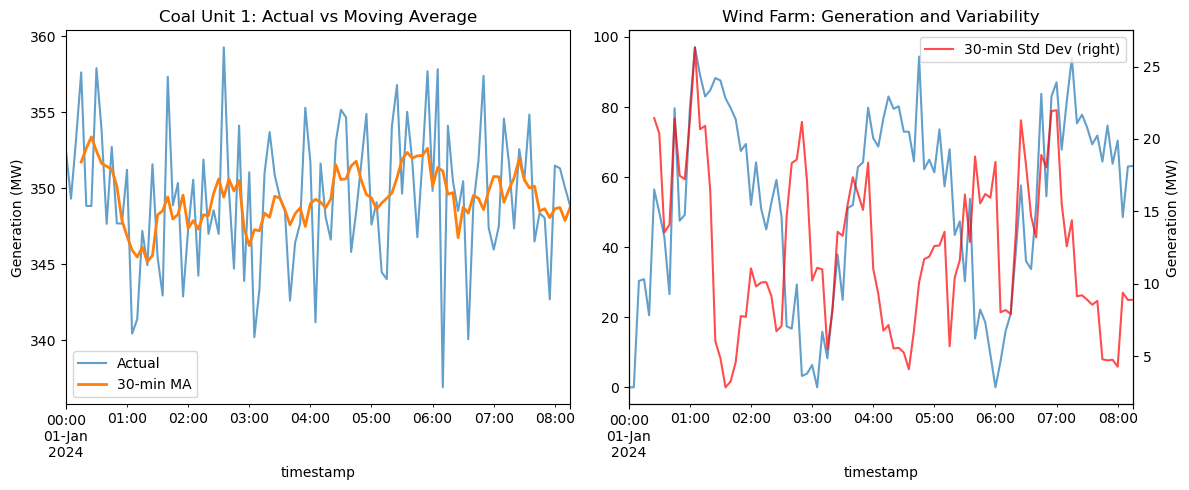

In [15]:
# 2. Rolling calculations - Moving averages for smoothing
print("=== Rolling Calculations ===")
# 30-minute rolling average (6 periods of 5 minutes)
gen_df['coal_unit_1_ma30'] = gen_df['coal_unit_1'].rolling(window=6, center=True).mean()

# Calculate rolling standard deviation for variability analysis
gen_df['wind_farm_std30'] = gen_df['wind_farm'].rolling(window=6).std()

print("Sample of rolling calculations:")
print(gen_df[['coal_unit_1', 'coal_unit_1_ma30', 'wind_farm', 'wind_farm_std30']].iloc[10:15])

# Plot to visualize smoothing effect
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
gen_df['coal_unit_1'].iloc[:100].plot(label='Actual', alpha=0.7)
gen_df['coal_unit_1_ma30'].iloc[:100].plot(label='30-min MA', linewidth=2)
plt.title('Coal Unit 1: Actual vs Moving Average')
plt.ylabel('Generation (MW)')
plt.legend()

plt.subplot(1, 2, 2)
gen_df['wind_farm'].iloc[:100].plot(label='Wind Generation', alpha=0.7)
gen_df['wind_farm_std30'].iloc[:100].plot(label='30-min Std Dev', secondary_y=True, color='red', alpha=0.7)
plt.title('Wind Farm: Generation and Variability')
plt.ylabel('Generation (MW)')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# 3. Shift operations - Calculate ramp rates
print("=== Shift Operations: Calculating Ramp Rates ===")
# Ramp rate = change in generation between consecutive periods
for unit in ['coal_unit_1', 'gas_unit_1', 'wind_farm']:
    gen_df[f'{unit}_ramp'] = gen_df[unit].diff()  # Difference from previous period
    
# Convert to MW/minute (5-minute periods)
gen_df[['coal_unit_1_ramp', 'gas_unit_1_ramp', 'wind_farm_ramp']] /= 5

print("Ramp rates (MW/min):")
print(gen_df[['coal_unit_1', 'coal_unit_1_ramp', 'gas_unit_1', 'gas_unit_1_ramp']].iloc[50:55])

# Analyze ramp rate violations
# Compare with generator characteristics
print("\n=== Ramp Rate Analysis ===")
for unit_name in ['coal_unit_1', 'gas_unit_1', 'wind_farm']:
    if unit_name in generator_info['unit_name'].values:
        max_ramp = generator_info[generator_info['unit_name'] == unit_name]['ramp_rate_mw_min'].iloc[0]
        actual_ramps = gen_df[f'{unit_name}_ramp'].abs()
        violations = (actual_ramps > max_ramp).sum()
        max_actual = actual_ramps.max()
        print(f"{unit_name}: Max allowed: {max_ramp} MW/min, Max actual: {max_actual:.2f} MW/min, Violations: {violations}")

=== Shift Operations: Calculating Ramp Rates ===
Ramp rates (MW/min):
                     coal_unit_1  coal_unit_1_ramp  gas_unit_1  \
timestamp                                                        
2024-01-01 04:10:00       351.62              2.09      187.77   
2024-01-01 04:15:00       348.07             -0.71      189.05   
2024-01-01 04:20:00       346.62             -0.29      188.21   
2024-01-01 04:25:00       353.06              1.29      189.87   
2024-01-01 04:30:00       355.15              0.42      179.99   

                     gas_unit_1_ramp  
timestamp                             
2024-01-01 04:10:00            -0.53  
2024-01-01 04:15:00             0.26  
2024-01-01 04:20:00            -0.17  
2024-01-01 04:25:00             0.33  
2024-01-01 04:30:00            -1.98  

=== Ramp Rate Analysis ===
coal_unit_1: Max allowed: 5 MW/min, Max actual: 4.18 MW/min, Violations: 0
gas_unit_1: Max allowed: 10 MW/min, Max actual: 2.78 MW/min, Violations: 0
wind_farm: Max a

```{admonition} Exercise 3: Calculate Generator Ramp Rates
:class: tip

Using the generation data, analyze ramp rates to identify operational issues:

1. Calculate 5-minute ramp rates for all generators
2. Identify periods where any unit violates its ramp rate limit
3. Calculate the percentage of time each unit is ramping up vs down
4. Find the hour with the highest total system ramping

```

In [17]:
# Exercise 3: Your code here
# Analyze generator ramp rates

# Your solution:

In [18]:
# Solution
# 1. Calculate 5-minute ramp rates for all generators
gen_units = ['coal_unit_1', 'coal_unit_2', 'gas_unit_1', 'gas_unit_2', 'wind_farm', 'solar_farm']
ramp_df = pd.DataFrame(index=gen_df.index)

for unit in gen_units:
    # Calculate ramp in MW (positive = ramp up, negative = ramp down)
    ramp_df[f'{unit}_ramp_mw'] = gen_df[unit].diff()
    # Convert to MW/min
    ramp_df[f'{unit}_ramp_mw_min'] = ramp_df[f'{unit}_ramp_mw'] / 5

# 2. Identify ramp rate violations
print("=== Ramp Rate Violations ===")
violations_summary = {}

for unit in gen_units:
    if unit in generator_info['unit_name'].values:
        ramp_limit = generator_info[generator_info['unit_name'] == unit]['ramp_rate_mw_min'].iloc[0]
        ramp_col = f'{unit}_ramp_mw_min'
        
        # Find violations (absolute ramp rate exceeds limit)
        violations_mask = ramp_df[ramp_col].abs() > ramp_limit
        violations_count = violations_mask.sum()
        violations_summary[unit] = violations_count
        
        if violations_count > 0:
            print(f"\n{unit} (limit: {ramp_limit} MW/min):")
            print(f"  Violations: {violations_count}")
            print(f"  Max ramp up: {ramp_df[ramp_col].max():.2f} MW/min")
            print(f"  Max ramp down: {ramp_df[ramp_col].min():.2f} MW/min")
            # Show worst violations
            worst_violations = ramp_df[violations_mask].nlargest(3, ramp_col, keep='all')
            print(f"  Worst violations:")
            for idx, row in worst_violations.iterrows():
                print(f"    {idx}: {row[ramp_col]:.2f} MW/min")

# 3. Calculate ramping direction percentages
print("\n=== Ramping Direction Analysis ===")
for unit in gen_units:
    ramp_col = f'{unit}_ramp_mw'
    # Exclude first row (NaN) and near-zero ramps
    valid_ramps = ramp_df[ramp_col].dropna()
    ramp_up = (valid_ramps > 0.1).sum()  # Threshold to avoid noise
    ramp_down = (valid_ramps < -0.1).sum()
    steady = len(valid_ramps) - ramp_up - ramp_down
    
    total = len(valid_ramps)
    print(f"{unit}:")
    print(f"  Ramping up: {ramp_up/total*100:.1f}%")
    print(f"  Ramping down: {ramp_down/total*100:.1f}%")
    print(f"  Steady: {steady/total*100:.1f}%")

# 4. Find hour with highest system ramping
# Calculate total absolute ramping for each timestamp
ramp_df['total_ramping'] = sum(ramp_df[f'{unit}_ramp_mw'].abs() for unit in gen_units)

# Resample to hourly and sum absolute ramps
hourly_ramping = ramp_df['total_ramping'].resample('1H').sum()
max_ramp_hour = hourly_ramping.idxmax()
max_ramp_value = hourly_ramping.max()

print(f"\n=== Maximum System Ramping ===")
print(f"Hour with highest total ramping: {max_ramp_hour}")
print(f"Total ramping in that hour: {max_ramp_value:.1f} MW")

# Show unit contributions during that hour
print("\nUnit contributions during max ramping hour:")
max_hour_data = ramp_df[ramp_df.index.floor('H') == max_ramp_hour]
for unit in gen_units:
    unit_ramping = max_hour_data[f'{unit}_ramp_mw'].abs().sum()
    print(f"  {unit}: {unit_ramping:.1f} MW ({unit_ramping/max_ramp_value*100:.1f}%)")

=== Ramp Rate Violations ===

=== Ramping Direction Analysis ===
coal_unit_1:
  Ramping up: 50.5%
  Ramping down: 48.1%
  Steady: 1.4%
coal_unit_2:
  Ramping up: 48.8%
  Ramping down: 49.8%
  Steady: 1.4%
gas_unit_1:
  Ramping up: 49.8%
  Ramping down: 49.5%
  Steady: 0.7%
gas_unit_2:
  Ramping up: 50.9%
  Ramping down: 47.0%
  Steady: 2.1%
wind_farm:
  Ramping up: 50.2%
  Ramping down: 48.4%
  Steady: 1.4%
solar_farm:
  Ramping up: 23.7%
  Ramping down: 27.2%
  Steady: 49.1%

=== Maximum System Ramping ===
Hour with highest total ramping: 2024-01-01 06:00:00
Total ramping in that hour: 466.0 MW

Unit contributions during max ramping hour:
  coal_unit_1: 99.3 MW (21.3%)
  coal_unit_2: 35.8 MW (7.7%)
  gas_unit_1: 47.1 MW (10.1%)
  gas_unit_2: 32.2 MW (6.9%)
  wind_farm: 198.6 MW (42.6%)
  solar_farm: 53.0 MW (11.4%)


## 5. Aggregation and Grouping

Analyzing data by categories is essential for understanding power system patterns. Let's explore grouping by fuel type, time periods, and other relevant categories.

In [19]:
# First, reshape generation data to long format for easier grouping
gen_long = gen_df[gen_units].reset_index()
gen_melted = pd.melt(gen_long, id_vars=['timestamp'], var_name='unit_name', value_name='generation_mw')

# Merge with generator info to add fuel type
gen_with_info = gen_melted.merge(generator_info[['unit_name', 'fuel_type', 'capacity_mw']], on='unit_name')

# 1. Total generation by fuel type
print("=== Generation by Fuel Type ===")
fuel_generation = gen_with_info.groupby('fuel_type')['generation_mw'].agg(['sum', 'mean', 'std'])
fuel_generation['total_mwh'] = fuel_generation['sum'] / 12  # Convert to MWh
print(fuel_generation)

# 2. Capacity factors by technology
print("\n=== Capacity Factors by Technology ===")
# Calculate capacity factor = actual generation / (capacity * time)
capacity_factors = {}
for fuel in gen_with_info['fuel_type'].unique():
    fuel_data = gen_with_info[gen_with_info['fuel_type'] == fuel]
    total_generation = fuel_data['generation_mw'].sum() / 12  # MWh
    total_capacity = fuel_data.groupby('unit_name')['capacity_mw'].first().sum()
    time_hours = len(gen_df) / 12  # Total hours
    capacity_factor = total_generation / (total_capacity * time_hours) * 100
    capacity_factors[fuel] = capacity_factor

cf_df = pd.DataFrame(list(capacity_factors.items()), columns=['Fuel Type', 'Capacity Factor (%)'])
print(cf_df.sort_values('Capacity Factor (%)', ascending=False))

=== Generation by Fuel Type ===
                   sum    mean    std  total_mwh
fuel_type                                       
Coal         179955.51  312.42  37.82   14996.29
Natural Gas   72122.04  125.21  38.49    6010.17
Solar          4198.05   14.58  18.96     349.84
Wind          14765.87   51.27  26.47    1230.49

=== Capacity Factors by Technology ===
     Fuel Type  Capacity Factor (%)
0         Coal                89.26
1  Natural Gas                71.55
2         Wind                51.27
3        Solar                24.29


=== Hourly Generation Patterns ===


<Figure size 1200x600 with 0 Axes>

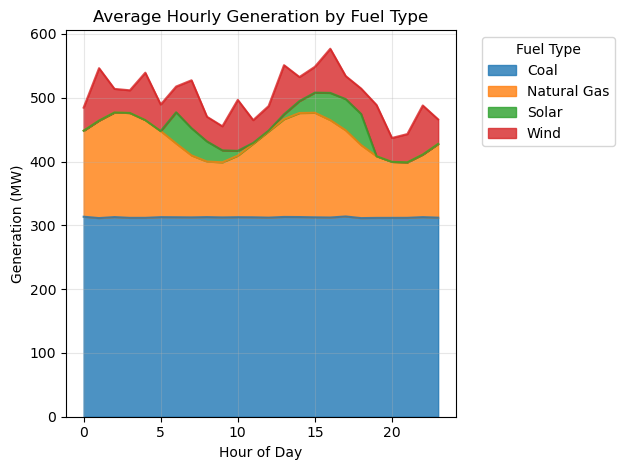


=== Peak vs Off-Peak Analysis ===
                        mean        sum  total_mwh
period   fuel_type                                
Off-Peak Coal         312.35   59970.89    4997.57
         Natural Gas  141.93   27251.11    2270.93
         Solar          6.12     587.23      48.94
         Wind          48.16    4623.44     385.29
Peak     Coal         312.46  119984.62    9998.72
         Natural Gas  116.85   44870.92    3739.24
         Solar         18.81    3610.81     300.90
         Wind          52.83   10142.43     845.20


In [20]:
# 3. Time-based grouping - hourly patterns
print("=== Hourly Generation Patterns ===")
gen_with_info['hour'] = gen_with_info['timestamp'].dt.hour
hourly_by_fuel = gen_with_info.groupby(['hour', 'fuel_type'])['generation_mw'].mean().unstack()

# Plot hourly patterns by fuel type
plt.figure(figsize=(12, 6))
hourly_by_fuel.plot(kind='area', stacked=True, alpha=0.8)
plt.title('Average Hourly Generation by Fuel Type')
plt.xlabel('Hour of Day')
plt.ylabel('Generation (MW)')
plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Peak vs off-peak analysis
print("\n=== Peak vs Off-Peak Analysis ===")
# Define peak hours (typically 7 AM - 10 PM)
gen_with_info['period'] = gen_with_info['hour'].apply(
    lambda h: 'Peak' if 7 <= h <= 22 else 'Off-Peak'
)

period_analysis = gen_with_info.groupby(['period', 'fuel_type'])['generation_mw'].agg(['mean', 'sum'])
period_analysis['total_mwh'] = period_analysis['sum'] / 12
print(period_analysis)

```{admonition} Exercise 4: Analyze Generation Patterns
:class: tip

Perform a comprehensive analysis of generation patterns:

1. Calculate the average capacity factor for each individual generator
2. Find the hour of day when renewable penetration is highest
3. Compare weekday vs weekend generation patterns (simulate weekend data)
4. Identify which fuel type has the most variable generation (highest coefficient of variation)

```

In [21]:
# Exercise 4: Your code here
# Analyze generation patterns

# Your solution:

In [22]:
# Solution
# 1. Calculate capacity factor for each generator
print("=== Capacity Factors by Generator ===")
unit_capacity_factors = {}

for unit in gen_units:
    if unit in generator_info['unit_name'].values:
        # Get capacity
        capacity = generator_info[generator_info['unit_name'] == unit]['capacity_mw'].iloc[0]
        # Calculate average generation
        avg_generation = gen_df[unit].mean()
        # Capacity factor as percentage
        cf = (avg_generation / capacity) * 100
        unit_capacity_factors[unit] = cf

# Create DataFrame and sort
cf_results = pd.DataFrame(list(unit_capacity_factors.items()), 
                         columns=['Generator', 'Capacity Factor (%)'])
cf_results = cf_results.sort_values('Capacity Factor (%)', ascending=False)
print(cf_results)

# 2. Find hour with highest renewable penetration
print("\n=== Renewable Penetration Analysis ===")
# Calculate hourly renewable and total generation
gen_with_info['is_renewable'] = gen_with_info['fuel_type'].isin(['Wind', 'Solar'])
hourly_gen = gen_with_info.groupby(['hour', 'is_renewable'])['generation_mw'].sum().unstack(fill_value=0)
hourly_gen.columns = ['Conventional', 'Renewable']
hourly_gen['Total'] = hourly_gen.sum(axis=1)
hourly_gen['Renewable_Penetration_%'] = (hourly_gen['Renewable'] / hourly_gen['Total'] * 100)

max_renewable_hour = hourly_gen['Renewable_Penetration_%'].idxmax()
max_renewable_pct = hourly_gen['Renewable_Penetration_%'].max()

print(f"Hour with highest renewable penetration: {max_renewable_hour}:00")
print(f"Renewable penetration: {max_renewable_pct:.1f}%")
print(f"Generation mix at hour {max_renewable_hour}:")
print(f"  Renewable: {hourly_gen.loc[max_renewable_hour, 'Renewable']:.1f} MW")
print(f"  Conventional: {hourly_gen.loc[max_renewable_hour, 'Conventional']:.1f} MW")

# 3. Simulate weekend data (lower load, different patterns)
# For this exercise, create a simple weekend simulation
gen_df_copy = gen_df.copy()
gen_df_copy['day_of_week'] = gen_df_copy.index.dayofweek
gen_df_copy['is_weekend'] = gen_df_copy['day_of_week'].isin([5, 6])

# Simulate: on weekends, conventional generation is 10% lower, renewables unchanged
weekend_factor = 0.9
for unit in ['coal_unit_1', 'coal_unit_2', 'gas_unit_1', 'gas_unit_2']:
    gen_df_copy.loc[gen_df_copy['is_weekend'], unit] *= weekend_factor

# Compare weekday vs weekend
weekday_avg = gen_df_copy[~gen_df_copy['is_weekend']][gen_units].mean()
weekend_avg = gen_df_copy[gen_df_copy['is_weekend']][gen_units].mean()

comparison = pd.DataFrame({
    'Weekday Avg (MW)': weekday_avg,
    'Weekend Avg (MW)': weekend_avg,
    'Difference (%)': (weekend_avg - weekday_avg) / weekday_avg * 100
})

print("\n=== Weekday vs Weekend Comparison ===")
print(comparison)

# 4. Find most variable fuel type (coefficient of variation)
print("\n=== Generation Variability by Fuel Type ===")
fuel_cv = gen_with_info.groupby('fuel_type')['generation_mw'].agg(['mean', 'std'])
fuel_cv['coefficient_of_variation'] = fuel_cv['std'] / fuel_cv['mean'] * 100
fuel_cv = fuel_cv.sort_values('coefficient_of_variation', ascending=False)

print(fuel_cv)
print(f"\nMost variable fuel type: {fuel_cv.index[0]} (CV: {fuel_cv.iloc[0]['coefficient_of_variation']:.1f}%)")

=== Capacity Factors by Generator ===
     Generator  Capacity Factor (%)
1  coal_unit_2                91.63
0  coal_unit_1                87.49
2   gas_unit_1                75.06
3   gas_unit_2                66.87
4    wind_farm                51.27
5   solar_farm                24.29

=== Renewable Penetration Analysis ===
Hour with highest renewable penetration: 7:00
Renewable penetration: 12.6%
Generation mix at hour 7:
  Renewable: 1413.4 MW
  Conventional: 9829.9 MW

=== Weekday vs Weekend Comparison ===
             Weekday Avg (MW)  Weekend Avg (MW)  Difference (%)
coal_unit_1            349.94               NaN             NaN
coal_unit_2            274.90               NaN             NaN
gas_unit_1             150.13               NaN             NaN
gas_unit_2             100.30               NaN             NaN
wind_farm               51.27               NaN             NaN
solar_farm              14.58               NaN             NaN

=== Generation Variability by Fu

## 6. Merging Power System Datasets

In practice, power system analysis often requires combining data from multiple sources. Let's explore different merge operations relevant to power systems.

In [23]:
# Load our datasets
gen_df = pd.read_csv('generation_data.csv', parse_dates=['timestamp'], index_col='timestamp')
load_df = pd.read_csv('load_data.csv', parse_dates=['timestamp'], index_col='timestamp')
price_df = pd.read_csv('market_prices.csv', parse_dates=['timestamp'], index_col='timestamp')

# 1. Merge generation with load data - typical for supply/demand analysis
print("=== Merging Generation and Load Data ===")
supply_demand = gen_df.merge(load_df, left_index=True, right_index=True, how='inner')
supply_demand['total_generation'] = supply_demand[gen_units].sum(axis=1)
supply_demand['supply_margin_mw'] = supply_demand['total_generation'] - supply_demand['system_load']
supply_demand['supply_margin_pct'] = supply_demand['supply_margin_mw'] / supply_demand['system_load'] * 100

print("Supply-demand summary:")
print(supply_demand[['total_generation', 'system_load', 'supply_margin_mw', 'supply_margin_pct']].describe())

# Find periods with tight margins
tight_margins = supply_demand[supply_demand['supply_margin_pct'] < 5]
print(f"\nPeriods with supply margin < 5%: {len(tight_margins)}")
if len(tight_margins) > 0:
    print("Tightest margins:")
    print(tight_margins[['total_generation', 'system_load', 'supply_margin_pct']].head())

=== Merging Generation and Load Data ===
Supply-demand summary:
       total_generation  system_load  supply_margin_mw  supply_margin_pct
count            288.00       288.00            288.00             288.00
mean             941.12       600.65            340.46              59.30
std               63.69        78.79             95.98              22.85
min              792.24       433.64            107.37              14.90
25%              893.11       539.64            277.86              42.30
50%              940.00       597.37            342.18              58.05
75%             1001.55       664.44            407.58              73.37
max             1074.76       752.45            565.78             126.24

Periods with supply margin < 5%: 0


In [24]:
# 2. Create generator bid data and merge with market outcomes
# Simulate simple bid data
np.random.seed(42)
bid_times = pd.date_range('2024-01-01 10:00', periods=12, freq='1H')

bid_data = []
for t in bid_times:
    for unit in ['coal_unit_1', 'coal_unit_2', 'gas_unit_1', 'gas_unit_2']:
        # Get unit info
        unit_info = generator_info[generator_info['unit_name'] == unit].iloc[0]
        base_cost = unit_info['variable_cost_per_mwh']
        capacity = unit_info['capacity_mw']
        
        # Create bid segments (typical for generators)
        for segment in range(3):
            bid_data.append({
                'timestamp': t,
                'unit_name': unit,
                'segment': segment + 1,
                'quantity_mw': capacity / 3,
                'price_per_mwh': base_cost * (1 + segment * 0.1)  # Increasing price for each segment
            })

bids_df = pd.DataFrame(bid_data)
print("\n=== Generator Bid Data ===")
print(bids_df.head(10))

# Merge bids with actual generation (hourly)
gen_hourly = gen_df.resample('1H').mean()
gen_hourly_long = gen_hourly.reset_index().melt(id_vars=['timestamp'], var_name='unit_name', value_name='actual_mw')

# Merge bid and actual data
bid_vs_actual = bids_df.merge(
    gen_hourly_long, 
    on=['timestamp', 'unit_name'], 
    how='inner'
)

# Calculate which bid segments were accepted (simplified)
bid_vs_actual['cumulative_mw'] = bid_vs_actual.groupby(['timestamp', 'unit_name'])['quantity_mw'].cumsum()
bid_vs_actual['segment_accepted'] = bid_vs_actual['cumulative_mw'] <= bid_vs_actual['actual_mw']

print("\n=== Bid Acceptance Analysis ===")
acceptance_rate = bid_vs_actual.groupby('segment')['segment_accepted'].mean() * 100
print("Acceptance rate by bid segment:")
for seg, rate in acceptance_rate.items():
    print(f"  Segment {seg}: {rate:.1f}%")


=== Generator Bid Data ===
            timestamp    unit_name  segment  quantity_mw  price_per_mwh
0 2024-01-01 10:00:00  coal_unit_1        1       133.33           25.0
1 2024-01-01 10:00:00  coal_unit_1        2       133.33           27.5
2 2024-01-01 10:00:00  coal_unit_1        3       133.33           30.0
3 2024-01-01 10:00:00  coal_unit_2        1       100.00           26.0
4 2024-01-01 10:00:00  coal_unit_2        2       100.00           28.6
5 2024-01-01 10:00:00  coal_unit_2        3       100.00           31.2
6 2024-01-01 10:00:00   gas_unit_1        1        66.67           35.0
7 2024-01-01 10:00:00   gas_unit_1        2        66.67           38.5
8 2024-01-01 10:00:00   gas_unit_1        3        66.67           42.0
9 2024-01-01 10:00:00   gas_unit_2        1        50.00           40.0

=== Bid Acceptance Analysis ===
Acceptance rate by bid segment:
  Segment 1: 100.0%
  Segment 2: 79.2%
  Segment 3: 0.0%



=== Comprehensive Market Analysis ===
Correlation analysis:
             system_load  temperature  avg_lmp  wind_farm  solar_farm
system_load     1.00e+00         0.86     0.97  -5.79e-03        0.34
temperature     8.64e-01         1.00     0.85  -2.18e-02        0.35
avg_lmp         9.73e-01         0.85     1.00  -1.19e-02        0.32
wind_farm      -5.79e-03        -0.02    -0.01   1.00e+00       -0.08
solar_farm      3.41e-01         0.35     0.32  -7.99e-02        1.00


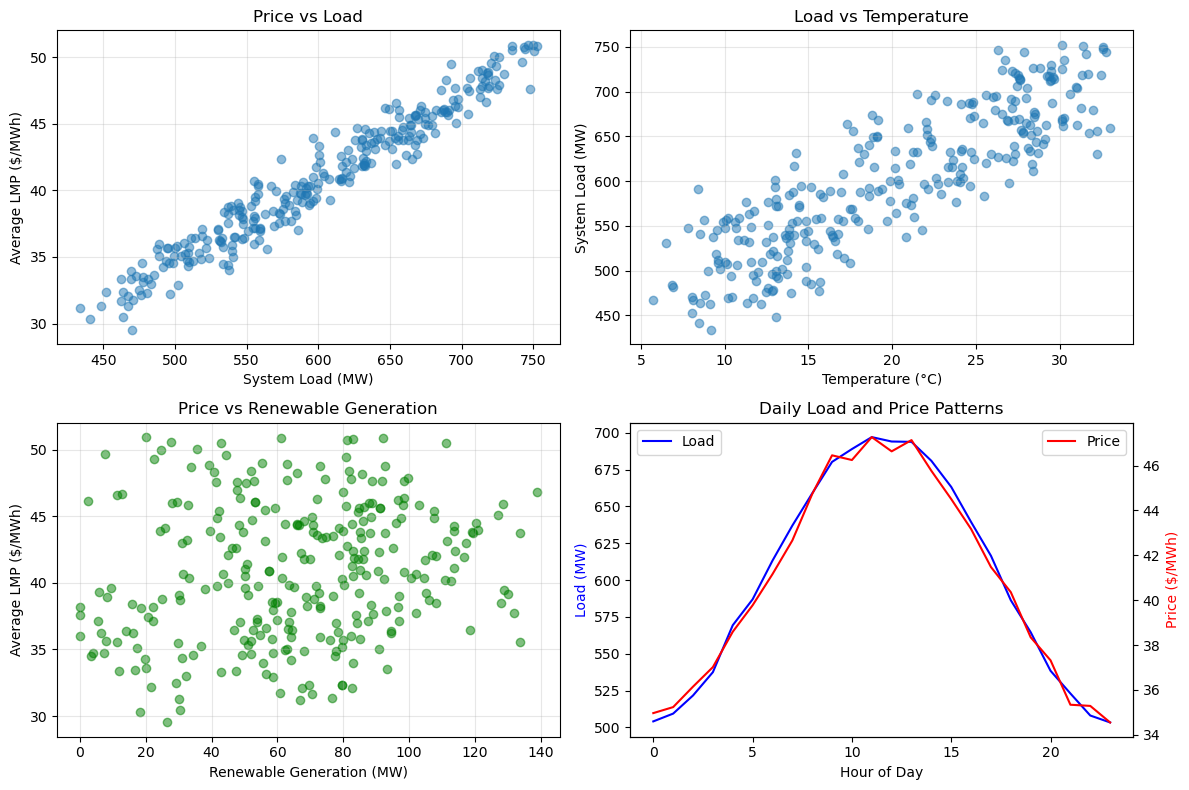

In [25]:
# 3. Merge all datasets for comprehensive analysis
print("\n=== Comprehensive Market Analysis ===")
# Merge generation, load, and prices
market_data = gen_df.merge(load_df, left_index=True, right_index=True, how='inner')
market_data = market_data.merge(price_df, left_index=True, right_index=True, how='inner')

# Calculate average LMP
market_data['avg_lmp'] = market_data[['lmp_node_1', 'lmp_node_2', 'lmp_node_3']].mean(axis=1)

# Calculate correlations
print("Correlation analysis:")
correlations = market_data[['system_load', 'temperature', 'avg_lmp', 'wind_farm', 'solar_farm']].corr()
print(correlations)

# Analyze price drivers
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(market_data['system_load'], market_data['avg_lmp'], alpha=0.5)
plt.xlabel('System Load (MW)')
plt.ylabel('Average LMP ($/MWh)')
plt.title('Price vs Load')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(market_data['temperature'], market_data['system_load'], alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('System Load (MW)')
plt.title('Load vs Temperature')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
renewable_gen = market_data['wind_farm'] + market_data['solar_farm']
plt.scatter(renewable_gen, market_data['avg_lmp'], alpha=0.5, color='green')
plt.xlabel('Renewable Generation (MW)')
plt.ylabel('Average LMP ($/MWh)')
plt.title('Price vs Renewable Generation')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
market_data['hour'] = market_data.index.hour
hourly_avg = market_data.groupby('hour')[['system_load', 'avg_lmp']].mean()
ax = hourly_avg['system_load'].plot(color='blue', label='Load')
ax2 = ax.twinx()
hourly_avg['avg_lmp'].plot(ax=ax2, color='red', label='Price')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Load (MW)', color='blue')
ax2.set_ylabel('Price ($/MWh)', color='red')
plt.title('Daily Load and Price Patterns')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

```{admonition} Exercise 5: Comprehensive Market Analysis
:class: tip

Perform a market analysis by merging generation bid data with cleared quantities:

1. Calculate the revenue for each generator based on actual generation and LMP
2. Identify hours when price spikes occur (LMP > $50/MWh)
3. Analyze the relationship between renewable generation and price congestion between nodes
4. Calculate the total market value of renewable vs conventional generation

```

In [26]:
# Exercise 5: Your code here
# Comprehensive market analysis

# Your solution:

In [27]:
# Solution
# 1. Calculate revenue for each generator
print("=== Generator Revenue Analysis ===")
# Use average LMP for all generators (simplified - in reality each would have location-specific price)
revenue_data = gen_df.copy()
revenue_data = revenue_data.merge(price_df[['lmp_node_1', 'lmp_node_2', 'lmp_node_3']], 
                                  left_index=True, right_index=True)
revenue_data['avg_lmp'] = revenue_data[['lmp_node_1', 'lmp_node_2', 'lmp_node_3']].mean(axis=1)

# Calculate revenue for each generator (generation * price / 12 to convert to MWh)
generator_revenue = {}
for unit in gen_units:
    revenue = (revenue_data[unit] * revenue_data['avg_lmp'] / 12).sum()
    generator_revenue[unit] = revenue

revenue_df = pd.DataFrame(list(generator_revenue.items()), columns=['Generator', 'Revenue ($)'])
revenue_df = revenue_df.merge(generator_info[['unit_name', 'fuel_type']], 
                             left_on='Generator', right_on='unit_name')
revenue_df = revenue_df.sort_values('Revenue ($)', ascending=False)
print(revenue_df[['Generator', 'fuel_type', 'Revenue ($)']])

# 2. Identify price spike hours
print("\n=== Price Spike Analysis ===")
spike_threshold = 50  # $/MWh
spike_mask = revenue_data['avg_lmp'] > spike_threshold
spike_hours = revenue_data[spike_mask]

print(f"Hours with average LMP > ${spike_threshold}/MWh: {len(spike_hours)}")
if len(spike_hours) > 0:
    print("\nPrice spikes occurred at:")
    for idx, row in spike_hours.iterrows():
        print(f"  {idx}: ${row['avg_lmp']:.2f}/MWh")
    
    # Analyze conditions during spikes
    spike_gen = spike_hours[gen_units].sum(axis=1)
    normal_gen = revenue_data[~spike_mask][gen_units].sum(axis=1)
    
    print(f"\nAverage total generation during spikes: {spike_gen.mean():.1f} MW")
    print(f"Average total generation during normal periods: {normal_gen.mean():.1f} MW")

# 3. Renewable generation vs price congestion
print("\n=== Renewable Impact on Congestion ===")
revenue_data['renewable_gen'] = revenue_data['wind_farm'] + revenue_data['solar_farm']
revenue_data['price_spread'] = revenue_data[['lmp_node_1', 'lmp_node_2', 'lmp_node_3']].std(axis=1)

# Bin renewable generation into quartiles
revenue_data['renewable_quartile'] = pd.qcut(revenue_data['renewable_gen'], 
                                             q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

congestion_by_renewable = revenue_data.groupby('renewable_quartile')['price_spread'].agg(['mean', 'std', 'max'])
print("Price spread (congestion indicator) by renewable generation level:")
print(congestion_by_renewable)

# 4. Total market value by fuel type
print("\n=== Market Value by Fuel Type ===")
# Merge generation with fuel type
gen_value = revenue_data[gen_units].T
gen_value.index.name = 'unit_name'
gen_value = gen_value.reset_index()
gen_value = gen_value.merge(generator_info[['unit_name', 'fuel_type']], on='unit_name')

# Calculate total energy and value by fuel type
fuel_value = {}
for fuel in gen_value['fuel_type'].unique():
    fuel_units = gen_value[gen_value['fuel_type'] == fuel]['unit_name'].values
    total_mwh = revenue_data[fuel_units].sum().sum() / 12
    total_value = sum((revenue_data[unit] * revenue_data['avg_lmp'] / 12).sum() 
                     for unit in fuel_units)
    avg_price = total_value / total_mwh if total_mwh > 0 else 0
    fuel_value[fuel] = {
        'Total MWh': total_mwh,
        'Total Value ($)': total_value,
        'Average Price ($/MWh)': avg_price
    }

value_summary = pd.DataFrame(fuel_value).T
print(value_summary)

# Calculate renewable vs conventional
renewable_value = value_summary.loc[['Wind', 'Solar'], 'Total Value ($)'].sum()
conventional_value = value_summary.loc[['Coal', 'Natural Gas'], 'Total Value ($)'].sum()
print(f"\nRenewable market value: ${renewable_value:,.2f} ({renewable_value/(renewable_value+conventional_value)*100:.1f}%)")
print(f"Conventional market value: ${conventional_value:,.2f} ({conventional_value/(renewable_value+conventional_value)*100:.1f}%)")

=== Generator Revenue Analysis ===
     Generator    fuel_type  Revenue ($)
0  coal_unit_1         Coal    343009.38
1  coal_unit_2         Coal    269427.20
2   gas_unit_1  Natural Gas    147154.64
3   gas_unit_2  Natural Gas     98322.99
4    wind_farm         Wind     50212.32
5   solar_farm        Solar     15020.93

=== Price Spike Analysis ===
Hours with average LMP > $50/MWh: 9

Price spikes occurred at:
  2024-01-01 09:15:00: $50.07/MWh
  2024-01-01 10:20:00: $50.51/MWh
  2024-01-01 11:10:00: $50.48/MWh
  2024-01-01 11:15:00: $50.88/MWh
  2024-01-01 12:10:00: $50.93/MWh
  2024-01-01 12:15:00: $50.59/MWh
  2024-01-01 13:05:00: $50.79/MWh
  2024-01-01 13:10:00: $50.73/MWh
  2024-01-01 13:15:00: $50.85/MWh

Average total generation during spikes: 932.2 MW
Average total generation during normal periods: 941.4 MW

=== Renewable Impact on Congestion ===
Price spread (congestion indicator) by renewable generation level:
                    mean   std   max
renewable_quartile          

## Summary

In this lesson, we've explored how Pandas can be applied to real-world power system data analysis tasks. Key takeaways include:

### Data Management
- Loading and exploring power system datasets from various sources
- Setting appropriate indexes for time-series operations
- Understanding data types and structures common in the industry

### Data Quality
- Identifying and handling missing values in SCADA data
- Detecting unrealistic measurements using domain knowledge
- Implementing appropriate interpolation strategies for time-series gaps

### Time Series Analysis
- Resampling data between different time resolutions
- Calculating rolling statistics for trend analysis
- Computing ramp rates and other derived metrics

### Aggregation and Grouping
- Analyzing generation patterns by fuel type
- Calculating capacity factors and performance metrics
- Identifying temporal patterns in power system operations

### Data Integration
- Merging datasets from different sources (generation, load, prices)
- Analyzing relationships between variables
- Performing comprehensive market analysis

## Next Steps

With these Pandas skills, you're prepared to:
- Analyze real operational data from ISOs and utilities
- Create reports on system performance and market outcomes
- Build data pipelines for power system analytics
- Prepare datasets for machine learning applications

In the next lesson, we'll explore data visualization techniques to effectively communicate insights from power system data analysis.

In [28]:
# Clean up temporary files
import os
for file in ['generation_data.csv', 'load_data.csv', 'market_prices.csv']:
    if os.path.exists(file):
        os.remove(file)
print("Cleaned up temporary CSV files")

Cleaned up temporary CSV files
